<a href="https://colab.research.google.com/github/manujism/Statistical-Arbitrage-Model/blob/main/stat_arb_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloaded Columns: MultiIndex([( 'Close', 'AXISBANK.NS'),
            ( 'Close', 'HDFCBANK.NS'),
            (  'High', 'AXISBANK.NS'),
            (  'High', 'HDFCBANK.NS'),
            (   'Low', 'AXISBANK.NS'),
            (   'Low', 'HDFCBANK.NS'),
            (  'Open', 'AXISBANK.NS'),
            (  'Open', 'HDFCBANK.NS'),
            ('Volume', 'AXISBANK.NS'),
            ('Volume', 'HDFCBANK.NS')],
           names=['Price', 'Ticker'])


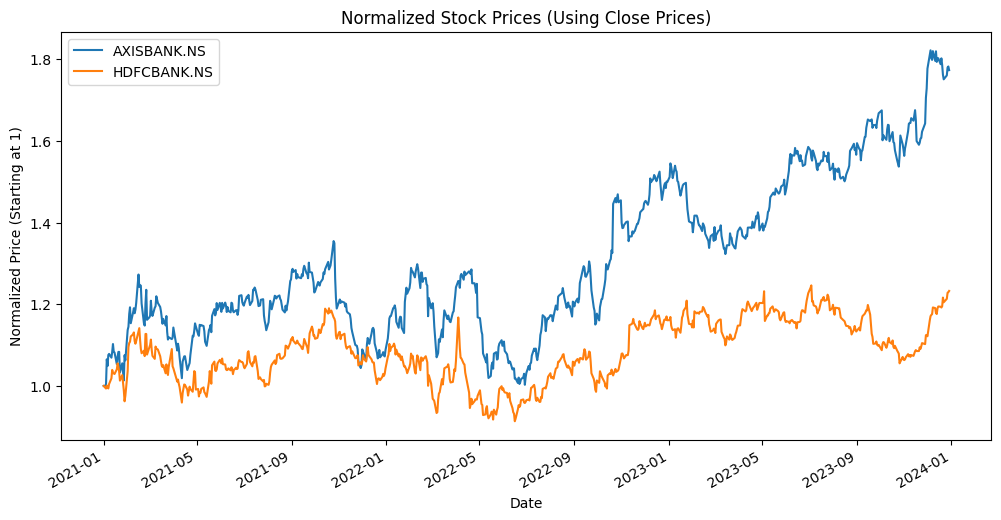

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


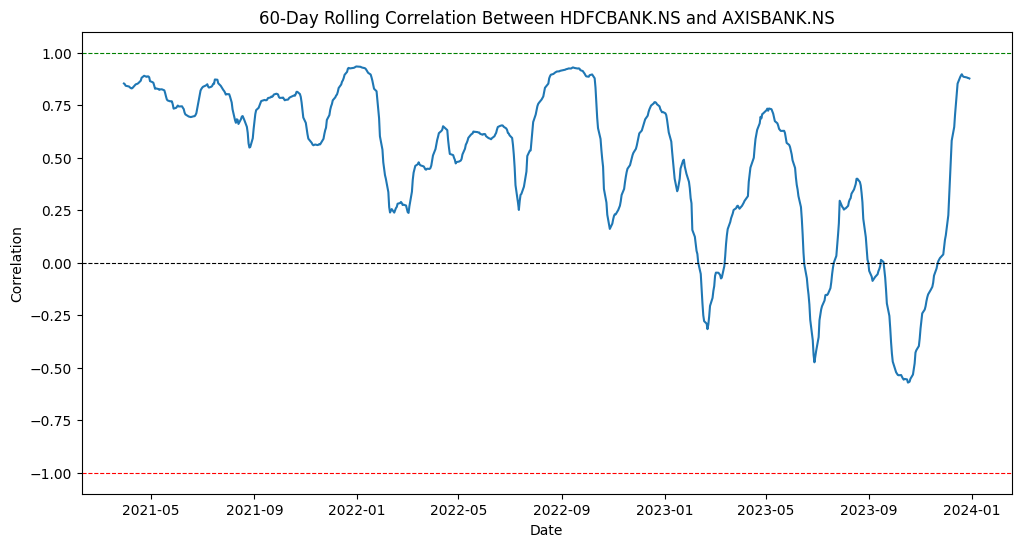

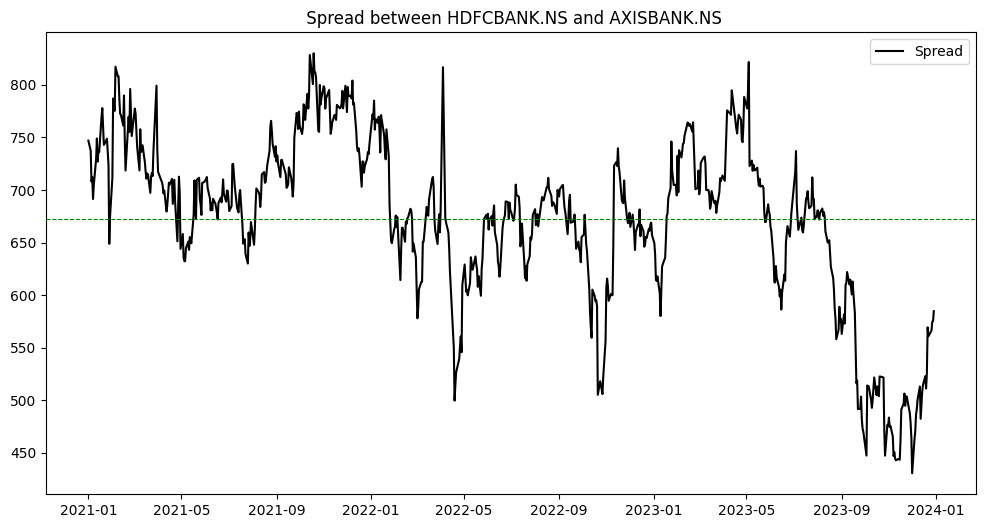

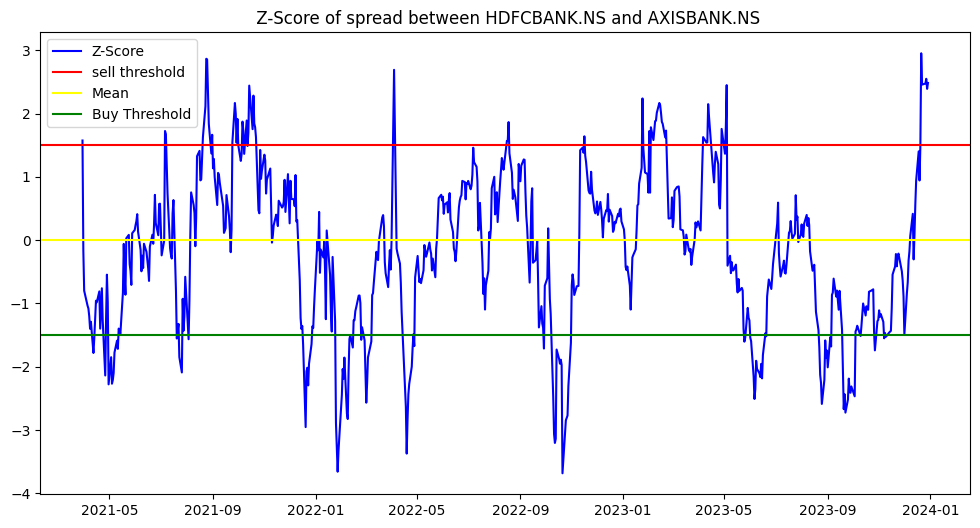

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

# Define tickers and date range
ticker = ['HDFCBANK.NS', 'AXISBANK.NS']
start_date = "2021-01-01"
end_date = "2023-12-31"

# Download stock data
df = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Debugging: Check available columns
print("Downloaded Columns:", df.columns)


df = df['Close']

# Normalize prices (divide each column by its first value)
normalized_df = df / df.iloc[0]

# Plot directly using pandas
normalized_df.plot(figsize=(12, 6), title="Normalized Stock Prices (Using Close Prices)")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Starting at 1)")
plt.legend()
plt.show()


print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


window = 60

rolling_corr = df[ticker[0]].rolling(window=window).corr(df[ticker[1]])


plt.figure(figsize=(12,6))
plt.plot(rolling_corr)
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.title(f"60-Day Rolling Correlation Between {ticker[0]} and {ticker[1]}")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line at 0
plt.axhline(1, color="green", linestyle="--", linewidth=0.8, label="Perfect Correlation (1)")
plt.axhline(-1, color="red", linestyle="--", linewidth=0.8, label="Perfect Negative Correlation (-1)")
plt.show()



#cointegration testing
#skipping this for now
#buliding pair strategy

spread = df[ticker[0]] - df[ticker[1]]
plt.figure(figsize=(12,6))
plt.plot(spread, label="Spread",  color="black")
plt.axhline(spread.mean(), color="green", linestyle="--" , linewidth=0.8)
plt.legend()
plt.title(f" Spread between {ticker[0]} and {ticker[1]}" )


#normalisation using z score
rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()

z_score = ( spread - rolling_mean ) / rolling_std
plt.figure(figsize=(12,6))
plt.plot(z_score, label="Z-Score" , color="blue")
plt.title(f" Z-Score of spread between {ticker[0]} and {ticker[1]}")
plt.axhline(1.5, label="sell threshold" , color="red")
plt.axhline(0, label="Mean" , color="yellow")
plt.axhline(-1.5, label="Buy Threshold" , color="green")
plt.legend()
plt.show()




buy_threshold = -1.5
sell_threshold = 1.5
exit_above_zero = 0
exit_below_zero = 0

position = 0
positions = []
buy_signals = []
sell_signals = []
exit_signals = []

for i, z in enumerate(z_score):
    if position == 0:  # Neutral position

        if z < buy_threshold:
            position = 1  # Buy signal (Long position)
            buy_signals.append(i)

        elif z > sell_threshold:
            position = -1  # Sell signal (Short position)
            sell_signals.append(i)

    elif position == 1:  # Long position
        if z > exit_above_zero:
            position = 0  # Exit long position
            exit_signals.append(i)

    elif position == -1:  # Short position
        if z < exit_below_zero:
            position = 0  # Exit short position
            exit_signals.append(i)

    positions.append(position)

positions = positions[:len(z_score)]

# Adding positions to the DataFrame
signals = pd.DataFrame(index=z_score.index)
signals['Position'] = positions
signals['Buy'] = signals.index.isin(z_score.index[buy_signals])
signals['Sell'] = signals.index.isin(z_score.index[sell_signals])
signals['Exit'] = signals.index.isin(z_score.index[exit_signals])

plt.figure(figsize=(12, 6))
plt.plot(z_score, label="Z-Score", color="green")
plt.axhline(buy_threshold, color="blue", linestyle="--", label="Buy Threshold (Z=-1.5)")
plt.axhline(sell_threshold, color="red", linestyle="--", label="Sell Threshold (Z=1.5)")
plt.axhline(0, color="black", linestyle="--", label="Mean (Z=0)")

# Plotting the trading signals
plt.scatter(signals.index[signals['Buy']], z_score[signals['Buy']],
            label="Buy Signal", color="blue", marker="^")
plt.scatter(signals.index[signals['Sell']], z_score[signals['Sell']],
            label="Sell Signal", color="red", marker="v")
plt.scatter(signals.index[signals['Exit']], z_score[signals['Exit']],
            label="Exit Signal", color="orange", marker="o")
plt.title(f"Z-Score and Trading Signals for Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()


initial_capital = 1000000
capital_per_stock = initial_capital / 2
df['Stock1_Position'] = capital_per_stock / df[tickers[0]].iloc[0]
df['Stock2_Position'] = capital_per_stock / df[tickers[1]].iloc[0]


